In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

from astroplan.plots import plot_airmass, plot_sky, plot_sky_24hr, plot_finder_image
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from astroplan import Observer

from pocs.scheduler.dispatch import Scheduler
from pocs.scheduler.constraint import AlreadyVisited, Duration, MoonAvoidance, Altitude
from pocs.utils.config import load_config
from pocs.utils import listify
from pocs.utils.horizon import Horizon

import logging

config = load_config()

In [4]:
# Get a location
loc = config['location']
location = EarthLocation(lon=loc['longitude'], lat=loc['latitude'], height=loc['elevation'])

# Get an observer at the location
observer = Observer(location=location)

# Create a horizon line
points = [
    ((40, 30), (40, 75)),  # From 30°-75° east there is an obstruction at 40° altitude
    ((50, -60), (40, -30)) # From 60°-30° west there is an obstruction sloping from 50° to 40° altitude
]
horizon = Horizon(points)

# Get the night hours (you can use observer.tonight())
times = observer.tonight(horizon=-18 * u.degree)
start_of_night = times[0]
end_of_night = times[1]
# start_of_night = Time('2016-08-13 10:00:00')
# end_of_night = Time('2016-08-13 16:00:00')

In [5]:
simple_fields_file = config['directories']['targets'] + '/simple.yaml'

# Simple constraint to maximize duration above a certain altitude
constraints = [AlreadyVisited(), MoonAvoidance(), Duration(30 * u.deg)]
constraints = [AlreadyVisited(), Altitude(horizon), MoonAvoidance(), Duration(30 * u.deg)]

# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

In [6]:
for obs in scheduler.observations.values():
    print(obs)

Kepler 1100: 120.0 s exposures in blocks of 10, minimum 60, priority 125
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 200
HD 23630: 120.0 s exposures in blocks of 10, minimum 60, priority 100
HD 189733: 100.0 s exposures in blocks of 10, minimum 60, priority 105
HD 209458: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 140: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 104: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 44: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 2: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 24: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 77: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 33: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 43: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 36: 120.0 s exposures in blocks of 10, minimum 60, priority 100
Wasp 11: 120.0 s exp

In [7]:
# Get the best observations for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(time=start_of_night, show_all=True)

for b in listify(best):
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: CoRoT-18     Merit: 202.3220647772819
Field: Wasp 35      Merit: 202.03480563499681
Field: Wasp 33      Merit: 201.72962664908442
Field: Wasp 77      Merit: 201.5670638382877
Field: M42          Merit: 177.13043661663085


In [8]:
scheduler.current_observation.field.coord.equinox

<Time object: scale='utc' format='jyear_str' value=J2000.000>

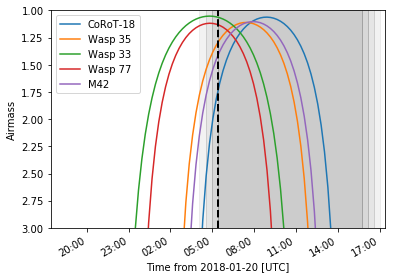

In [9]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, start_of_night, 
             brightness_shading=True)
        
plt.axvline(start_of_night.plot_date, lw=2, ls='--', c='k')    
plt.legend(loc=2)
plt.show()

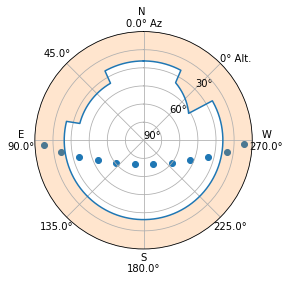

In [10]:
ax = plot_sky_24hr(scheduler.current_observation.field, scheduler.observer, start_of_night)

# Show horizon

# Scale from 0 - 100 where 100 = 0° and 0 = 90°
y = (100 - (horizon.horizon_line * 100) / 90)
# 0 - 2π spread across 360
x = np.linspace(0, 2 * np.pi, 360)
ax.plot(x, y)
ax.fill_between(x, y, 100, alpha=0.2)

plt.show()

In [11]:
# Set a later time to start
t2 = end_of_night - 3 * u.hour

# Get the best observation for the given time
# show_all returns entire list along with merit
best = scheduler.get_observation(show_all=True, time=t2)

for b in best:
    print("Field: {:12s} Merit: {}".format(b[0], b[1]))

Field: Wasp 43      Merit: 202.86697472045543
Field: Qatar-2      Merit: 202.78933258368687
Field: HAT-P-36     Merit: 202.77467695226636
Field: M44          Merit: 152.61639598540523


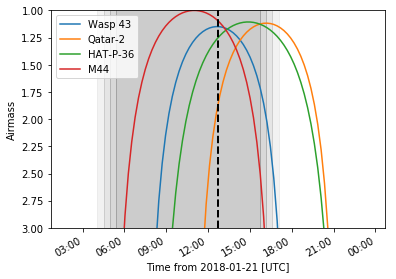

In [12]:
plot_airmass([scheduler.observations[name].field for name, merit in best], 
             scheduler.observer, t2, 
             brightness_shading=True)
plt.axvline(t2.plot_date, lw=2, ls='--', c='k')
plt.legend(loc=2)
plt.show()

## Entire Night Simulation

Now let's simulate going through the whole evening

In [13]:
# Start at the beginning of the night
next_time = start_of_night
print("Start of night at {}".format(start_of_night.isot))

# Reset scheduler
# Create a scheduler
scheduler = Scheduler(observer, fields_file=simple_fields_file, constraints=constraints)

while (next_time < end_of_night):    
    # Only get new target if we have met min_nexp for observation
    if (scheduler.current_observation is None) or \
        (scheduler.current_observation.current_exp >= scheduler.current_observation.min_nexp):
        
        print("Getting new observation at {}".format(next_time.isot))
        new_obs = scheduler.get_observation(time=next_time)
        
    if scheduler.current_observation is not None:

        if (scheduler.current_observation.current_exp < scheduler.current_observation.min_nexp):
            obs_duration = scheduler.current_observation.minimum_duration

            # Fake the exposure count
            scheduler.current_observation.current_exp = scheduler.current_observation.min_nexp
        else:
            obs_duration = scheduler.current_observation.set_duration
            # Fake the exposure count
            scheduler.current_observation.current_exp += scheduler.current_observation.exp_set_size

        print("\tWill observe {} with merit of {:0.5f} for {}".format(
                    scheduler.current_observation.name, 
                    scheduler.current_observation.merit, 
                    obs_duration))
        print("\t{} of {}".format(scheduler.current_observation.current_exp, 
                                  scheduler.current_observation.min_nexp))
                
    next_time = next_time + obs_duration
    
print("End of night at {}".format(end_of_night.isot))

Start of night at 2018-01-21T05:24:25.064
Getting new observation at 2018-01-21T05:24:25.064
	Will observe CoRoT-18 with merit of 202.32206 for 7200.0 s
	60 of 60
Getting new observation at 2018-01-21T07:24:25.064
	Will observe HAT-P-30 with merit of 202.61827 for 7200.0 s
	60 of 60
Getting new observation at 2018-01-21T09:24:25.064
	Will observe Wasp 104 with merit of 202.94821 for 7200.0 s
	60 of 60
Getting new observation at 2018-01-21T11:24:25.064
	Will observe HAT-P-36 with merit of 202.77436 for 7200.0 s
	60 of 60
Getting new observation at 2018-01-21T13:24:25.064
	Will observe Wasp 104 with merit of 202.93329 for 7200.0 s
	60 of 60
Getting new observation at 2018-01-21T15:24:25.064
End of night at 2018-01-21T15:42:40.727


In [14]:
time = Time('2016-08-13 11:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 13:00:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

time = Time('2016-08-13 14:30:00')
scheduler.get_observation(time=time)
print(scheduler.current_observation)

KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 200
KIC 8462852: 120.0 s exposures in blocks of 10, minimum 60, priority 200
None


In [15]:
print(scheduler.current_observation)

None
